In [1]:
from math import *
import pandas as pd
import numpy as np
import statistics as st
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import lagrange
from pyproj import Transformer
import re
from leven import levenshtein       
from sklearn.cluster import dbscan
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from shapely import geometry 
import itertools
import warnings
warnings.filterwarnings('ignore')

#webscraping packages
import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

#multiprocessing for faster webscraping
from multiprocessing.dummy import Pool

from datetime import datetime, timedelta
import difflib #for finding closest word match
import os
import ipdb as ipdb
%pdb off

Automatic pdb calling has been turned OFF


In [2]:
#reading in entire database of aircraft N-Number and Engine Mfr Code
aircraft_data_master = pd.read_csv('ReleasableAircraft/MASTER.txt')[['N-NUMBER', 'ENG MFR MDL']]
aircraft_data_master = aircraft_data_master[aircraft_data_master['ENG MFR MDL'] != '     ']
aircraft_data_master['ENG MFR MDL'] = aircraft_data_master['ENG MFR MDL'].astype(np.int64)

#reading in Engine database (Engine Mfr Code and Model Name)
aircraft_data_engine = pd.read_csv('ReleasableAircraft/ENGINE.txt')[['CODE', 'MODEL']]
aircraft_data_engine = aircraft_data_engine.rename(columns = {'CODE': 'ENG MFR MDL'})

#merge two databases ==> relates N-Number (tail number) of aircraft to Model Name to find fuel flow later
aircraft_model_names = aircraft_data_master.merge(aircraft_data_engine, on = 'ENG MFR MDL', how = 'left')
aircraft_model_names['N-NUMBER'] = 'N' + aircraft_model_names['N-NUMBER'].astype(str)
aircraft_model_names = aircraft_model_names.rename(columns = {'N-NUMBER': 'TailNumber'})
aircraft_model_names = aircraft_model_names.set_index('TailNumber')
aircraft_model_names.index = [index.strip() for index in aircraft_model_names.index]

In [3]:
aircraft_data_master = pd.read_csv('ReleasableAircraft/MASTER.txt')
aircraft_data_master = aircraft_data_master[aircraft_data_master['ENG MFR MDL'] != '     ']
aircraft_data_master['ENG MFR MDL'] = aircraft_data_master['ENG MFR MDL'].astype(np.int64)

In [4]:
#reading in fuel flow and emissions index data
fuel_flow_emissions = pd.read_excel('Emissions Data/emissions_indices.xlsx').rename(columns = {'Engine Identification': 'MODEL'})
fuel_flow_emissions = fuel_flow_emissions[['MODEL', 'Fuel Flow T/O (kg/sec)', 'Fuel Flow C/O (kg/sec)', 'Fuel Flow App (kg/sec)', 'Fuel Flow Idle (kg/sec)',
                                           'HC EI T/O (g/kg)', 'HC EI C/O (g/kg)', 'HC EI App (g/kg)', 'HC EI Idle (g/kg)',
                                           'CO EI T/O (g/kg)', 'CO EI C/O (g/kg)', 'CO EI App (g/kg)', 'CO EI Idle (g/kg)',
                                           'NOx EI T/O (g/kg)', 'NOx EI C/O (g/kg)', 'NOx EI App (g/kg)', 'NOx EI Idle (g/kg)', 
                                           'SN T/O', 'SN C/O', 'SN App', 'SN Idle']]
fuel_flow_emissions = fuel_flow_emissions.dropna()
fuel_flow_emissions = fuel_flow_emissions.groupby('MODEL', as_index=False).mean()
fuel_flow_emissions = fuel_flow_emissions.set_index('MODEL')
fuel_flow_emissions = fuel_flow_emissions.rename(columns={'SN T/O': 'SN EI T/O', 'SN C/O': 'SN EI C/O', 'SN App': 'SN EI App', 'SN Idle': 'SN EI Idle'})

In [5]:
takeoff = [100]*len(fuel_flow_emissions)
climbout = [85]*len(fuel_flow_emissions)
approach = [30]*len(fuel_flow_emissions)
taxi_idle = [7]*len(fuel_flow_emissions)
fuel_flow_emissions['Takeoff'] = takeoff; fuel_flow_emissions['Climb Out'] = climbout
fuel_flow_emissions['Approach'] = approach; fuel_flow_emissions['Taxi/Idle'] = taxi_idle

In [6]:
columns = ['Fuel Flow T/O (kg/sec)','Fuel Flow Idle (kg/sec)',
           'HC EI T/O (kg/sec)','HC EI Idle (kg/sec)',
           'CO EI T/O (kg/sec)','CO EI Idle (kg/sec)',
           'NOx EI T/O (kg/sec)','NOx EI Idle (kg/sec)',
           'SN T/O','SN Idle']

In [7]:
fuel_flow_emissions

,Fuel Flow T/O (kg/sec),Fuel Flow C/O (kg/sec),Fuel Flow App (kg/sec),Fuel Flow Idle (kg/sec),HC EI T/O (g/kg),HC EI C/O (g/kg),HC EI App (g/kg),HC EI Idle (g/kg),CO EI T/O (g/kg),CO EI C/O (g/kg),...,NOx EI App (g/kg),NOx EI Idle (g/kg),SN EI T/O,SN EI C/O,SN EI App,SN EI Idle,Takeoff,Climb Out,Approach,Taxi/Idle
MODEL,,,,,,,,,,,,,,,,,,,,,
AE3007A,0.3770,0.3150,0.1170,0.0490,0.25000,0.29000,0.64000,2.5100,0.7500,0.9200,...,7.7900,3.8300,1.0000,0.00,0.00,0.00,100,85,30,7
AE3007A1,0.3826,0.3180,0.1130,0.0461,0.07025,0.07925,0.22375,4.1395,0.5975,0.5225,...,7.1400,3.7500,0.2575,0.01,0.01,0.01,100,85,30,7
AE3007A1 series,0.3800,0.3190,0.1170,0.0500,0.26000,0.30000,0.72000,3.1000,0.7900,0.9700,...,7.2200,3.5200,1.0000,0.00,0.00,0.00,100,85,30,7
AE3007A1/1,0.3805,0.3163,0.1125,0.0459,0.07050,0.07950,0.22450,4.1950,0.5625,0.5175,...,7.1175,3.7475,0.2575,0.01,0.01,0.01,100,85,30,7
AE3007A1/3,0.3589,0.2999,0.1077,0.0449,0.07325,0.08225,0.23975,4.3725,0.4575,0.5075,...,6.8825,3.8050,0.2575,0.01,0.01,0.01,100,85,30,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V2530-A5,1.3310,1.0770,0.3770,0.1380,0.04500,0.04100,0.05600,0.1000,0.4500,0.5200,...,10.1000,5.0000,4.9000,6.40,4.60,2.40,100,85,30,7
V2530-A5 SelectOne™ Upgrade Package,1.3250,1.0780,0.3870,0.1450,0.02000,0.03000,0.06000,0.1200,0.3900,0.4100,...,10.9200,5.5200,3.7000,6.60,5.70,1.40,100,85,30,7
V2531-E5,1.3290,1.0790,0.3910,0.1440,0.01000,0.02000,0.09000,0.0700,0.3900,0.4100,...,11.1400,5.5800,2.3000,6.00,6.30,1.30,100,85,30,7


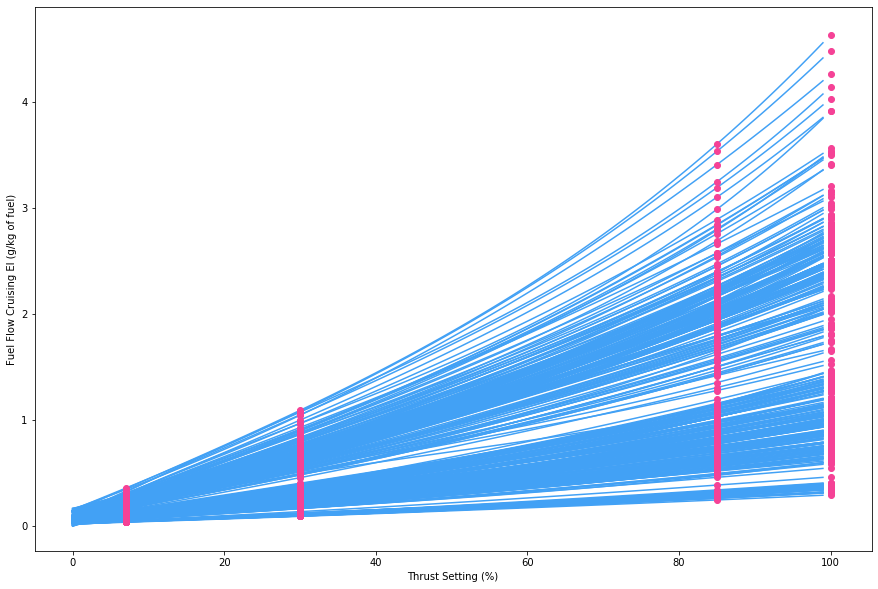

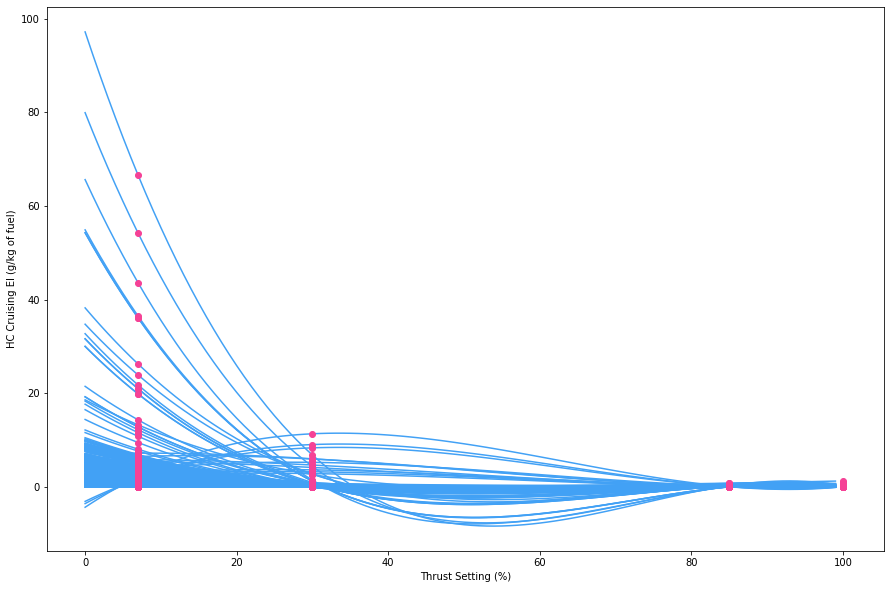

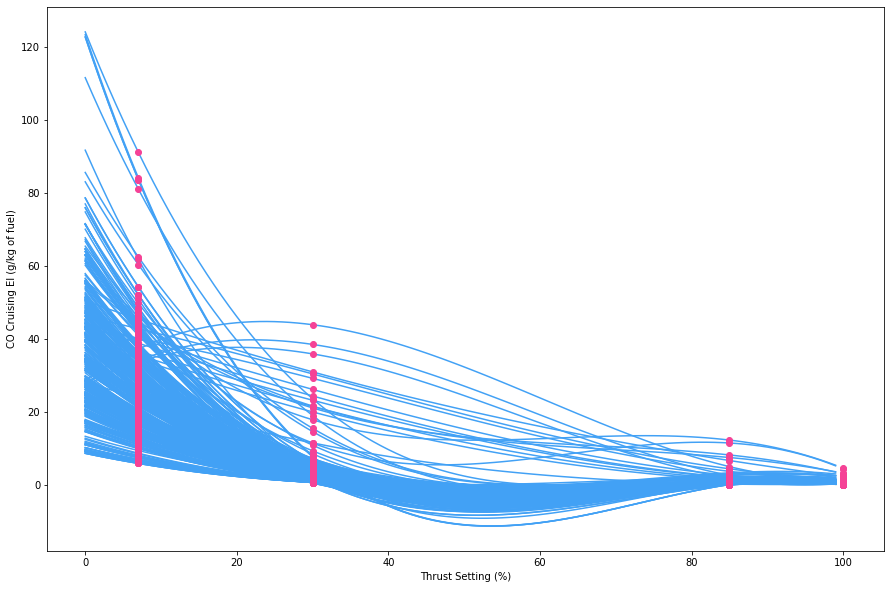

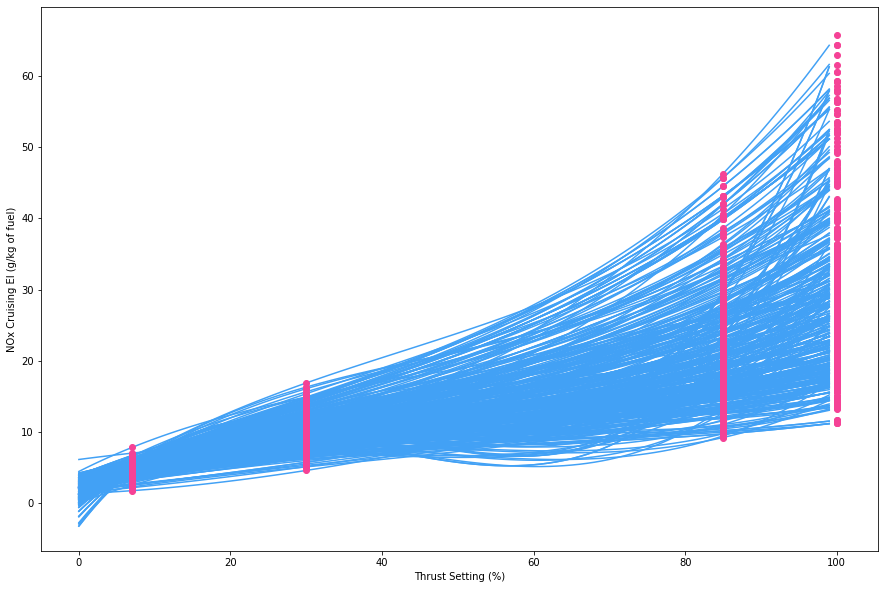

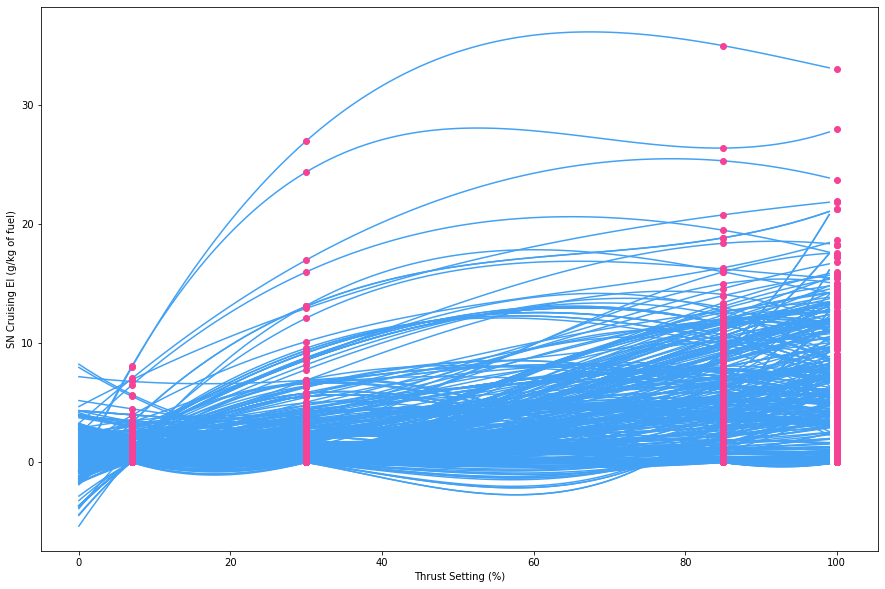

In [8]:
#parse out columns of interest
columns_of_interest = ['Fuel Flow T/O (kg/sec)','Fuel Flow Idle (kg/sec)',
           'HC EI T/O (g/kg)','HC EI Idle (g/kg)',
           'CO EI T/O (g/kg)','CO EI Idle (g/kg)',
           'NOx EI T/O (g/kg)','NOx EI Idle (g/kg)',
           'SN EI T/O','SN EI Idle']

#for each type of aircraft, estimate fuel flow and EI for each pollutant
for ii in range(int(len(columns_of_interest)/2)):
    if ii == 0:
        new_name = 'Fuel Flow Cruising'
    else:
        new_name = re.search(r'\w+(?=\sEI)', columns_of_interest[2*ii]).group(0) + ' Cruising'
    new_list = []
    fig = plt.figure(figsize = (15,10))
    for jj in fuel_flow_emissions.index:
        x = list(fuel_flow_emissions.loc[jj, 'Takeoff':'Taxi/Idle'])
        x_new = range(100)
        y = list(fuel_flow_emissions.loc[jj, columns_of_interest[2*ii]:columns_of_interest[2*ii + 1]])
        f = lagrange(x, y)
        plt.plot(x_new, f(x_new), '#42a1f5', zorder = 1) 
        plt.scatter(x, y, c = '#f54296', zorder = 2)
        plt.xlabel('Thrust Setting (%)')
        plt.ylabel(new_name + ' EI (g/kg of fuel)')
        cruise_addition = f(80)
        if cruise_addition < 0:
            slope = (y[2] - y[1]) / (x[2] - x[1])
            b = y[1] - slope * x[1]
            cruise_addition = slope * 80 + b            
        new_list.append(cruise_addition)
    fuel_flow_emissions[new_name] = new_list
    
fuel_flow_emissions = fuel_flow_emissions.drop(['Takeoff', 'Climb Out', 'Approach', 'Taxi/Idle'], axis = 1)

In [9]:
fuel_flow_emissions

,Fuel Flow T/O (kg/sec),Fuel Flow C/O (kg/sec),Fuel Flow App (kg/sec),Fuel Flow Idle (kg/sec),HC EI T/O (g/kg),HC EI C/O (g/kg),HC EI App (g/kg),HC EI Idle (g/kg),CO EI T/O (g/kg),CO EI C/O (g/kg),...,NOx EI Idle (g/kg),SN EI T/O,SN EI C/O,SN EI App,SN EI Idle,Fuel Flow Cruising,HC Cruising,CO Cruising,NOx Cruising,SN Cruising
MODEL,,,,,,,,,,,,,,,,,,,,,
AE3007A,0.3770,0.3150,0.1170,0.0490,0.25000,0.29000,0.64000,2.5100,0.7500,0.9200,...,3.8300,1.0000,0.00,0.00,0.00,0.295061,0.259799,0.653946,16.506999,0.000000
AE3007A1,0.3826,0.3180,0.1130,0.0461,0.07025,0.07925,0.22375,4.1395,0.5975,0.5225,...,3.7500,0.2575,0.01,0.01,0.01,0.297175,0.092386,0.900227,15.249577,0.010000
AE3007A1 series,0.3800,0.3190,0.1170,0.0500,0.26000,0.30000,0.72000,3.1000,0.7900,0.9700,...,3.5200,1.0000,0.00,0.00,0.00,0.299008,0.258188,0.593820,15.896652,0.000000
AE3007A1/1,0.3805,0.3163,0.1125,0.0459,0.07050,0.07950,0.22450,4.1950,0.5625,0.5175,...,3.7475,0.2575,0.01,0.01,0.01,0.295604,0.092682,0.900682,15.180970,0.010000
AE3007A1/3,0.3589,0.2999,0.1077,0.0449,0.07325,0.08225,0.23975,4.3725,0.4575,0.5075,...,3.8050,0.2575,0.01,0.01,0.01,0.280671,0.096568,0.945000,14.568580,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V2530-A5,1.3310,1.0770,0.3770,0.1380,0.04500,0.04100,0.05600,0.1000,0.4500,0.5200,...,5.0000,4.9000,6.40,4.60,2.40,0.999962,0.039721,0.326858,25.108659,6.651821
V2530-A5 SelectOne™ Upgrade Package,1.3250,1.0780,0.3870,0.1450,0.02000,0.03000,0.06000,0.1200,0.3900,0.4100,...,5.5200,3.7000,6.60,5.70,1.40,1.002833,0.031645,0.215079,21.996150,7.223627
V2531-E5,1.3290,1.0790,0.3910,0.1440,0.01000,0.02000,0.09000,0.0700,0.3900,0.4100,...,5.5800,2.3000,6.00,6.30,1.30,1.003579,0.026141,0.216875,22.282580,6.857084


In [10]:
def prepare_dataframe(file_path):
    #read in file and convert to dataframe
    if file_path[-3:] == 'xls':
        df = pd.read_html(file_path)[0]
        df.columns = df.columns.droplevel(0) #drop Multiindex header
        df = df[df.columns[:-1]] #drop last column
        flight_data = df[['ActualAirborneTime', 'ActualBlockTime','Carrier', 'FlightNumber', 'TailNumber', 'Departure', 'Arrival', 'AircraftType', 'ScheduledDepartureDate', 'ActualWheelsOff', 'ActualWheelsOn']]
        return flight_data
    elif file_path[-3:] == 'csv':
        df = pd.read_csv(file_path, header = 1)
        col_names = list(df)
        col_names = [re.search('\w+(?=\\xa0)', word).group(0) for word in col_names]
        df.columns = col_names
        flight_data = df[['ActualAirborneTime', 'ActualBlockTime','Carrier', 'FlightNumber', 'TailNumber', 'Departure', 'Arrival', 'AircraftType', 'ScheduledDepartureDate', 'ActualWheelsOff', 'ActualWheelsOn']]
        flight_data = flight_data.dropna()

        for col in list(flight_data):
            current_column = flight_data[col]
            flight_data[col] = [re.search('.+(?=\\xa0)', value).group(0) for value in current_column]
        return flight_data

# Compiling all 2019 CA flights into one dataframe

**If compiling small airports, run section below:**

In [ ]:
#get folder of all airport-specific data directories
folder_name = 'ASPM_Data_Small'
directory_contents = os.listdir(folder_name)
directory_contents.remove('.DS_Store')
directory_contents.sort(key = str.upper)

#list all file path names for future looping
file_path_names = []
for aa in directory_contents:
    yy = os.listdir(folder_name + '/' + aa)
    for kk in yy:
        full_name = folder_name + '/' + aa + '/' + kk
        file_path_names.append(full_name)

**Else if compiling the 5 large airports (LAX, SFO, OAK, SJC, SAN), change folder name accordingly and run section below:**

In [ ]:
#for larger airports, run this code
folder_name = 'ASPM_Data_SJC'
file_contents = os.listdir(folder_name)
try:
    file_contents.remove('.DS_Store')
except:
    pass
file_contents.sort(key = str.upper)
file_path_names = []
for aa in file_contents:
    yy = folder_name+ '/' + aa
    file_path_names.append(yy)

In [ ]:
#loop through all small airports to compile one dataframe of all flights
print(datetime.now())
flight_data_SJC = pd.DataFrame()
for file in file_path_names:
    print(file)
    xx = prepare_dataframe(file)
    flight_data_SJC = pd.concat([flight_data_SJC, xx], ignore_index = True).drop_duplicates()
print(datetime.now())

In [ ]:
#save compiled flight data:
flight_data_SJC.to_csv('Flight Data Compiled/flight_data_SJC.csv')

**Run code below to combine all airport flight data into one dataframe:**

In [ ]:
small_airports_2019_df = pd.read_csv('Flight Data Compiled/flight_data_small_airports.csv')
LAX_2019_df = pd.read_csv('Flight Data Compiled/flight_data_LAX.csv')
SFO_2019_df = pd.read_csv('Flight Data Compiled/flight_data_SFO.csv')
SAN_2019_df = pd.read_csv('Flight Data Compiled/flight_data_SAN.csv')
SJC_2019_df = pd.read_csv('Flight Data Compiled/flight_data_SJC.csv')
OAK_2019_df = pd.read_csv('Flight Data Compiled/flight_data_OAK.csv')

all_CA_airports_2019_df = pd.concat([small_airports_2019_df, LAX_2019_df, SFO_2019_df, SAN_2019_df, 
                                     SJC_2019_df, OAK_2019_df], ignore_index = True).drop_duplicates()
all_CA_airports_2019_df = all_CA_airports_2019_df.drop(all_CA_airports_2019_df.columns[[0]], axis = 1)
all_CA_airports_2019_df.to_csv('Flight Data Compiled/all_CA_airports_2019.csv', index = False)

In [28]:
f = pd.read_csv('airports.dat.txt', header = None)
f = f.rename(columns = {0: 'ID', 1: 'Name', 2: 'City', 3: 'Country', 4: 'IATA', 5: 'ICAO', 6: 'Latitude', 7: 'Longitude',
         8: 'Altitude', 9: 'Timezone', 10: 'DST', 11: 'Tz Database Timzone', 12: 'Type', 13: 'Source'})
f = f[f['Country'] == 'United States']
f = f[['IATA', 'ICAO', 'Latitude', 'Longitude']]

In [29]:
#seperate international flights from domestic-US flights
all_CA_flights_2019 = pd.read_csv('Flight Data Compiled/all_CA_airports_2019.csv')
all_US_CA_flights_2019 = all_CA_flights_2019[(all_CA_flights_2019['Departure'].isin(f['IATA'])) & (all_CA_flights_2019['Arrival'].isin(f['IATA']))]


In [30]:
all_US_CA_flights_2019

,ActualAirborneTime,ActualBlockTime,Carrier,FlightNumber,TailNumber,Departure,Arrival,AircraftType,ScheduledDepartureDate,ActualWheelsOff,ActualWheelsOn
0,60,76,CFS,8712,CFS8712,SMF,ACV,AT43,02/13/2019,19:12,20:12
1,52,70,CFS,8712,CFS8712,SMF,ACV,AT43,05/08/2019,16:23,17:15
2,52,70,CFS,8712,CFS8712,SMF,ACV,AT43,05/09/2019,16:32,17:24
3,49,65,CFS,8712,CFS8712,SMF,ACV,AT43,02/11/2019,15:06,15:55
4,47,62,CFS,8712,CFS8712,SMF,ACV,AT43,02/12/2019,14:49,15:36
...,...,...,...,...,...,...,...,...,...,...,...
2237351,90,104,XSN,20,XSN20,OAK,VGT,PC12,06/14/2019,11:16,12:46
2237352,92,112,XSN,20,XSN20,OAK,VGT,PC12,06/01/2019,08:12,09:44
2237353,155,167,XSN,32,XSN32,OAK,ASE,PC12,06/07/2019,16:30,20:05
2237354,88,94,YEL,5,YEL5,OAK,CGZ,E55P,06/21/2019,09:46,11:14


In [183]:
ca_iata_codes = list(pd.read_csv('CA_airports.csv')['AIRPORTID'])
intra_CA = all_US_CA_flights_2019[all_US_CA_flights_2019.Departure.isin(ca_iata_codes)]
intra_CA = intra_CA[intra_CA.Arrival.isin(ca_iata_codes)]
out_of_CA = all_US_CA_flights_2019[~all_US_CA_flights_2019.index.isin(intra_CA.index)]

In [106]:
out_of_CA

,ActualAirborneTime,ActualBlockTime,Carrier,FlightNumber,TailNumber,Departure,Arrival,AircraftType,ScheduledDepartureDate,ActualWheelsOff,ActualWheelsOn
23,76,105,DPJ,817,DPJ817,SEA,ACV,C56X,01/03/2019,10:26,11:42
31,140,163,GAJ,841,GAJ841,LAS,ACV,B350,04/10/2019,12:15,14:34
33,69,86,GAJ,865,GAJ865,PDX,ACV,B350,02/03/2019,07:45,08:53
42,220,240,LXJ,452,LXJ452,MSP,ACV,GLF4,10/15/2019,12:49,14:28
43,212,229,LXJ,452,LXJ452,MSP,ACV,GLF4,04/20/2019,14:18,15:49
...,...,...,...,...,...,...,...,...,...,...,...
2237349,98,112,XOJ,794,XOJ794,OAK,BFI,C750,06/01/2019,09:29,11:07
2237351,90,104,XSN,20,XSN20,OAK,VGT,PC12,06/14/2019,11:16,12:46
2237352,92,112,XSN,20,XSN20,OAK,VGT,PC12,06/01/2019,08:12,09:44
2237353,155,167,XSN,32,XSN32,OAK,ASE,PC12,06/07/2019,16:30,20:05


In [195]:
def od_pair_name_addition(df):
    a = df[['Departure', 'Arrival']].values
    a = np.sort(a)
    a_df = pd.DataFrame(a)
    a_df = pd.Series(a_df[0] + a_df[1])
    insert = pd.concat([a_df, pd.Series(df.index)], axis = 1).set_index(1)
    df_return = pd.concat([insert, df], axis = 1).rename(columns = {0: 'OD Pair Name'})
    return df_return

In [196]:
out_of_CA = od_pair_name_addition(out_of_CA)

In [197]:
out_of_CA

,OD Pair Name,ActualAirborneTime,ActualBlockTime,Carrier,FlightNumber,TailNumber,Departure,Arrival,AircraftType,ScheduledDepartureDate,ActualWheelsOff,ActualWheelsOn
23,ACVSEA,76,105,DPJ,817,DPJ817,SEA,ACV,C56X,01/03/2019,10:26,11:42
31,ACVLAS,140,163,GAJ,841,GAJ841,LAS,ACV,B350,04/10/2019,12:15,14:34
33,ACVPDX,69,86,GAJ,865,GAJ865,PDX,ACV,B350,02/03/2019,07:45,08:53
42,ACVMSP,220,240,LXJ,452,LXJ452,MSP,ACV,GLF4,10/15/2019,12:49,14:28
43,ACVMSP,212,229,LXJ,452,LXJ452,MSP,ACV,GLF4,04/20/2019,14:18,15:49
...,...,...,...,...,...,...,...,...,...,...,...,...
2237349,BFIOAK,98,112,XOJ,794,XOJ794,OAK,BFI,C750,06/01/2019,09:29,11:07
2237351,OAKVGT,90,104,XSN,20,XSN20,OAK,VGT,PC12,06/14/2019,11:16,12:46
2237352,OAKVGT,92,112,XSN,20,XSN20,OAK,VGT,PC12,06/01/2019,08:12,09:44
2237353,ASEOAK,155,167,XSN,32,XSN32,OAK,ASE,PC12,06/07/2019,16:30,20:05


## Straight-Line Method for Determining Portion of Flight Within CA

In [174]:
def lat_lon_merge(airport_df, loc_df):
    #merge on departures
    dep_merge = airport_df.merge(loc_df, left_on = 'Departure', right_on = 'IATA', how = 'left')
    dep_merge = dep_merge.drop(['IATA', 'ICAO'], axis = 1)
    dep_merge = dep_merge.rename(columns = {'Latitude': 'Dep Lat', 'Longitude': 'Dep Lon'})

    #merge on arrivals
    arr_merge = dep_merge.merge(loc_df, left_on = 'Arrival', right_on = 'IATA', how = 'left')
    arr_merge = arr_merge.drop(['IATA', 'ICAO'], axis = 1)
    arr_merge = arr_merge.rename(columns = {'Latitude': 'Arr Lat', 'Longitude': 'Arr Lon'})
    return arr_merge

In [ ]:
#read in data for CA vertices, define CA linear ring 
ca_vertices = pd.read_csv('ca_vertices.csv').dropna()
x_coords = ca_vertices['xcoord']
y_coords = ca_vertices['ycoord']

ca_shape_points = [geometry.Point(i) for i in list(zip(x_coords, y_coords))]
ca_shape = geometry.polygon.LinearRing([[p.x, p.y] for p in ca_shape_points])

In [252]:
#define function to create OD Pair Label
def compare_od_pairs(row):
    alph_od_pair = ''.join(sorted([row[5], row[6]]))
    return alph_od_pair

from pyproj import Proj, transform

#define function to convert lat/lon coordinates to x,y coordinates
def convert_to_xy(lon, lat):
    inProj  = Proj("+init=EPSG:4326")
    outProj = Proj("+init=EPSG:3857")
    return transform(inProj, outProj, lon, lat)

ca_iata_codes = list(pd.read_csv('CA_airports.csv')['AIRPORTID'])

In [244]:
with_locations = lat_lon_merge(out_of_CA, f)
insert = with_locations.apply(compare_od_pairs, axis = 1)
with_locations.insert(0, 'OD Pair Name', insert)
unique_OD = list(np.unique(np.array(with_locations['OD Pair Name'])))

In [325]:
#this cell takes ~30-40 minutes to run; do not run if already run once (output saves to CSV below)
emissions_frac_within_CA = {}
for od_idx in unique_OD:
    first_airport = od_idx[0:3]
    second_airport = od_idx[3:6]
    f_lon, f_lat = f[f['IATA'] == first_airport]['Longitude'].values[0], f[f['IATA'] == first_airport]['Latitude'].values[0]
    s_lon, s_lat = f[f['IATA'] == second_airport]['Longitude'].values[0], f[f['IATA'] == second_airport]['Latitude'].values[0]
    f_pt = list(convert_to_xy(f_lon, f_lat))
    s_pt = list(convert_to_xy(s_lon, s_lat))
    travel_line = geometry.LineString([f_pt, s_pt])
    if travel_line.intersects(ca_shape):
        intersection = travel_line.intersection(ca_shape)
        if type(intersection) == geometry.multipoint.MultiPoint:
            intersection = intersection[0]
        if first_airport in ca_iata_codes:
            frac_within_ca = geometry.LineString([f_pt, intersection]).length / travel_line.length
        else:
            frac_within_ca = geometry.LineString([s_pt, intersection]).length / travel_line.length
        emissions_frac_within_CA[od_idx] = frac_within_ca
    else:
        emissions_frac_within_CA[od_idx] = np.nan

In [374]:
frac_in_CA_df = pd.DataFrame.from_dict(emissions_frac_within_CA, orient = 'index').rename(columns = {0:'Frac in CA'})
frac_in_CA_df.to_csv('frac_in_CA.csv')


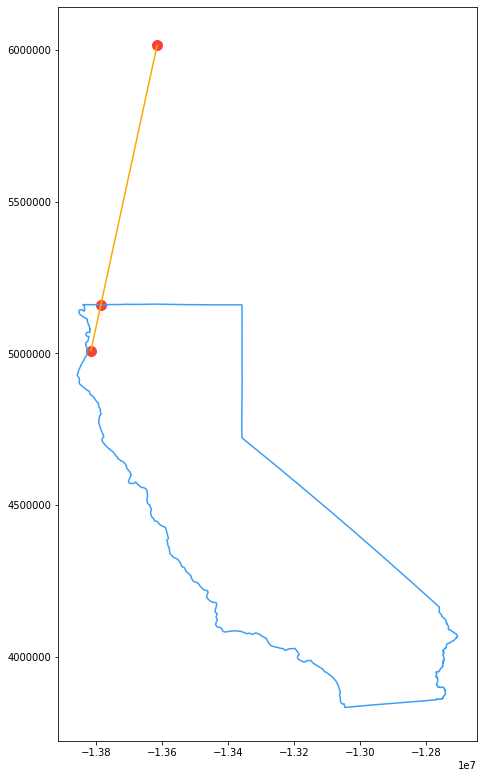

In [366]:
plt.figure(figsize = (5*1.5, 9*1.5))
x,y = ca_shape.xy
plt.plot(x, y, color = '#3c9efa')
plt.plot(*travel_line.xy, color= '#fca903')
plt.scatter(*intersection.xy, color = '#f74134', s = 100)
plt.scatter(*dep_point, color = '#f74134', s = 100)
plt.scatter(*arr_point, color = '#f74134', s = 100)
plt.show()

### Matching out-of-CA flights with Fraction of Flight Within State

In [201]:
frac_within_CA = pd.read_csv('frac_in_CA.csv')
frac_within_CA = frac_within_CA.rename(columns = {'Unnamed: 0': 'OD Pair Name'}).set_index('OD Pair Name')

In [157]:
frac_within_CA

,Frac in CA
OD Pair Name,
ABEBUR,0.088286
ABELAX,0.092574
ABEOAK,0.079250
ABEONT,0.075610
ABESFO,0.084558
...,...
VNYWYS,0.225897
VNYXNA,0.169053
VNYYIP,0.106599


In [202]:
out_of_CA = frac_within_CA.merge(out_of_CA, on = 'OD Pair Name', how = 'left')

In [209]:
out_of_CA

,OD Pair Name,Frac in CA,ActualAirborneTime,ActualBlockTime,Carrier,FlightNumber,TailNumber,Departure,Arrival,AircraftType,ScheduledDepartureDate,ActualWheelsOff,ActualWheelsOn
0,ABEBUR,0.088286,318,325,EJM,457,EJM457,ABE,BUR,GLF4,10/02/2019,09:51,12:09
1,ABEBUR,0.088286,261,249,EJM,457,EJM457,BUR,ABE,GLF4,10/05/2019,09:27,16:48
2,ABEBUR,0.088286,268,284,EJM,268,EJM268,BUR,ABE,CL30,08/07/2019,09:51,17:19
3,ABEBUR,0.088286,311,326,EJM,268,EJM268,ABE,BUR,CL30,08/05/2019,08:50,11:01
4,ABELAX,0.092574,329,356,DCM,2877,DCM2877,ABE,LAX,CL60,01/14/2019,07:43,10:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346730,VNYYKM,0.319663,118,128,DLX,401,DLX401,YKM,VNY,LJ60,07/09/2019,00:29,02:27
1346731,VNYYKM,0.319663,103,112,EJA,762,EJA762,YKM,VNY,CL35,12/28/2019,13:02,14:45
1346732,VNYYUM,0.961799,49,65,EJA,319,EJA319,VNY,YUM,E55P,05/12/2019,14:59,15:48
1346733,VNYYUM,0.961799,45,61,EJA,551,EJA551,VNY,YUM,C68A,01/21/2019,18:22,20:07


# Calculating Fuel Emissions (Method 1): Averaging Temp/Pres by Season and Time

In [174]:
#taken from: https://stackoverflow.com/questions/11384714/ignore-case-with-difflib-get-close-matches
def get_close_matches_icase(word, possibilities, *args, **kwargs):
    """ Case-insensitive version of difflib.get_close_matches """
    lword = word.lower()
    lpos = {}
    for p in possibilities:
        if p.lower() not in lpos:
            lpos[p.lower()] = [p]
        else:
            lpos[p.lower()].append(p)
    lmatches = difflib.get_close_matches(lword, lpos.keys(), *args, **kwargs)
    ret = [lpos[m] for m in lmatches]
    ret = itertools.chain.from_iterable(ret)
    return set(ret)

In [198]:
def calculate_fuel_emissions_fulldf(flight_data, out_of_state = 0):        
    print(datetime.now())
    #first merge: merging flight data with engine types for each flight 
    dfv1 = flight_data.merge(aircraft_model_names, left_on = 'TailNumber', right_index = True, how = 'outer')
    dfv1 = dfv1.drop('ENG MFR MDL', axis = 1);
    missing = dfv1[(dfv1['MODEL'].isnull()) & ~(dfv1['AircraftType'].isnull())] #only engine model is missing; aircraft type is not missing
    not_missing = dfv1[~(dfv1['AircraftType'].isnull()) & ~(dfv1['MODEL'].isnull())] #both engine model and ac type are not misisng 
    not_missing['MODEL'] = not_missing['MODEL'].str.strip()
    missing.index = missing.index.astype(int); not_missing.index = not_missing.index.astype(int)
    
    #creating dictionary matching aircraft type to engine models
    ac_type_model = not_missing[['AircraftType', 'MODEL']].drop_duplicates()
    ac_type_model = ac_type_model.dropna()
    drop_indices = ac_type_model[(ac_type_model['AircraftType'].str.len() != 4) & (ac_type_model['AircraftType'].str.len() != 3)].index
    ac_type_model = ac_type_model.drop(drop_indices)
    ac_types = [i[0] for i in ac_type_model.groupby('AircraftType')]
    
    #for loop below runs through present aircraft types and determines most likely engine pairing based on
    #density based clustering algorithm using levenshtein distance between strings
    ac_type_engine_dict = {}
    for aa in ac_types:
        matching_engines = list(ac_type_model[ac_type_model['AircraftType'] == aa]['MODEL'])
        try:
            #defining levenshtein distance for list of strings
            def lev_metric(x, y):
                i, j = int(x[0]), int(y[0])     # extract indices
                return levenshtein(matching_engines[i], matching_engines[j])
            X = np.arange(len(matching_engines)).reshape(-1, 1)
            grouping = list(dbscan(X, metric=lev_metric, eps=9, min_samples=2, algorithm='brute')[1])
            mode = matching_engines[grouping.index(st.mode(grouping))]
            approx_ac_type = re.search(r'.*(?=-)|.*(?=\s)', mode).group(0) + ' SERIES'
        except:
            mode = sorted(matching_engines)[0]
            try:
                approx_ac_type = re.search(r'.*(?=-)|.*(?=\s)', mode).group(0) + ' SERIES'
            except:
                approx_ac_type = mode + ' SERIES'
        ac_type_engine_dict[aa] = approx_ac_type
    
    #maps ac type to engine 
    mapping = missing['AircraftType'].map(ac_type_engine_dict, na_action='ignore')
    mapping = mapping.dropna()
    dfv1.loc[mapping.index, 'MODEL'] = mapping
    dfv1 = dfv1.dropna()
    dfv1['MODEL'] = dfv1['MODEL'].str.strip()
    dfv1.index = dfv1.index.astype(int)
    
    print('First merge made and approximations subsituted')
    first_loss = str(round(100 * (len(flight_data) - len(dfv1))/len(flight_data), 2))
    print('Data lost at 1st merge: ' + first_loss + '%')
    
    #create approximations of fuel flow for engine models not listed in fuel_flow_df
    missing_groups = list(set(dfv1['MODEL']) - set(fuel_flow_emissions.index))
    for kk in missing_groups:
        if 'SERIES' in kk:
            series_name = kk.replace(' SERIES', '')
            closest_matches = get_close_matches_icase(series_name, fuel_flow_emissions.index)
            approx_fuel_flow = fuel_flow_emissions.loc[closest_matches].mean(axis = 0) #returns a pd.Series 
            new_row = pd.concat([pd.Series([kk]), approx_fuel_flow])
            fuel_flow_emissions.loc[kk] = new_row
        else:
            closest_matches = get_close_matches_icase(kk, fuel_flow_emissions.index)
            approx_fuel_flow = fuel_flow_emissions.loc[closest_matches].mean(axis = 0) #returns a pd.Series 
            new_row = pd.concat([pd.Series([kk]), approx_fuel_flow])
            fuel_flow_emissions.loc[kk] = new_row
    print('Approximations for missing engine models made...')

    #second merge: merging dfv1 with fuel flow emissions by engine model
    dfv2 = dfv1.merge(fuel_flow_emissions, on = 'MODEL', how = 'left')
    dfv2 = dfv2.dropna()
    print('Second merge made...')
    second_loss = str(round((len(dfv1) - len(dfv2))/len(flight_data),2)*100)
    print('Data lost at 2nd merge: ' + second_loss + '%')
    
    month = dfv2.ScheduledDepartureDate.str[0:2].astype(int)
    time = dfv2['ActualWheelsOff'].str[0:2].astype(int)
    temp_array = dfv2[['FlightNumber']] * 0
    temp_array = temp_array.rename(columns = {'FlightNumber': 'Temperature'})
    
    #data averaged from https://www.usclimatedata.com/climate/winters/california/united-states/usca1252
    #low temperature == AM, high temperature == PM
    #spring, PM
    temp_array.loc[dfv2[((month == 3) | (month == 4) | (month == 5)) & ((time < 6) | (time >= 18))].index] = 49.3 + 459.67
    #spring, AM
    temp_array.loc[dfv2[((month == 3) | (month == 4) | (month == 5)) & ((time >= 6) | (time < 18))].index] = 76 + 459.67
    #summer, PM
    temp_array.loc[dfv2[((month == 6) | (month == 7) | (month == 8)) & ((time < 6) | (time >= 18))].index] = 60 + 459.67
    #summer, AM
    temp_array.loc[dfv2[((month == 6) | (month == 7) | (month == 8)) & ((time >= 6) | (time < 18))].index] = 95 + 459.67
    #fall, PM
    temp_array.loc[dfv2[((month == 9) | (month == 10) | (month == 11)) & ((time < 6) | (time >= 18))].index] = 51 + 459.67
    #fal, AM
    temp_array.loc[dfv2[((month == 9) | (month == 10) | (month == 11)) & ((time >= 6) | (time < 18))].index] = 79.7 + 459.67
    #winter, PM
    temp_array.loc[dfv2[((month == 12) | (month == 1) | (month == 2)) & ((time < 6) | (time >= 18))].index] = 39.3 + 459.67
    #winter, AM 
    temp_array.loc[dfv2[((month == 12) | (month == 1) | (month == 2)) & ((time >= 6) | (time < 18))].index] = 58.3 + 459.67
    dfv2['Temperature'] = temp_array
    dfv2['Pressure'] = [30/2.036]*len(dfv2)
    print('Temperature and pressure coefficients successfully calculated!...')
    
    #subfunction: calculate fuel emissions
    def calculate_fuel_emissions(temp, pres, ff_to, ff_co, ff_cr, ff_app, ff_idle, ei_to, ei_co, ei_cr, ei_app, ei_idle, fuel_cons, pollutant_type, airborne_time, block_time, frac_CA = None):
        coeff = ((temp/518.67)**3.5) / (pres/14.696) #temp and pressure coefficient 
        total_taxi_idle = block_time - airborne_time;
        cruise_time_approx = airborne_time - 0.7 - 2.2 - 4 #cruising time = total_airborne
        if pollutant_type == 'SN': #if the pollutant is SN == 'Smoke Number', the emissions indices
            #are not directly given, but calculated using the following equation (PM_ei)
            PM_ei = lambda SN: (6.32e-2 * SN + 8.17e-3 * SN**2 + 3.01e-4 * SN**3 + 4.05e-6 * SN**4) / 1.225 #divide by ambient air density (1.225 kg/m^3)
            ei_to = (PM_ei(ei_to) * 50) / 1000
            ei_co = (PM_ei(ei_co) * 60) / 1000
            ei_cr = (PM_ei(ei_cr) * (190/3)) / 1000
            ei_app = (PM_ei(ei_app) * 100) / 1000
            ei_idle = (PM_ei(ei_idle) * 120) / 1000

        #for intra-CA:
        to_cons = ff_to * 0.7 * 60; co_cons = ff_co * 2.2 * 60; 
        cr_cons = ff_cr * cruise_time_approx * 60; 
        app_cons = ff_app * 4 * 60; idle_cons = ff_idle * total_taxi_idle * 60
        
        #if OOC (out-of-CA), multiply by fraction of flight taking place within CA
        if frac_CA.any():
            to_cons *= frac_CA; co_cons*= frac_CA; cr_cons *= frac_CA
            app_cons *= frac_CA; idle_cons *= frac_CA
        
        #fuel emissions = fuel consumption (*_cons) * emissions index (ei)
        to = to_cons * ei_to
        co = co_cons * ei_co
        cr = cr_cons * ei_cr
        app = app_cons * ei_app
        idle = idle_cons * ei_idle
        
        #total fuel emissions = (temp/pressure coeff) * (takeoff + climbout + cruising + approach + idle)
        total_fuel_emissions = (coeff * (to + co + cr + app + idle)) / 1000 #[kg]
        if fuel_cons == 1:
            fuel_consumption_total = coeff * (to_cons + co_cons + app_cons + idle_cons)
            CO_2_emissions = 3.16 * fuel_consumption_total
            return cruise_time_approx, total_taxi_idle, fuel_consumption_total, CO_2_emissions, total_fuel_emissions
        else:
            return total_fuel_emissions
    
    column_names = list(dfv2)
    pollutant_type = ['HC', 'CO', 'NOx', 'SN']
    if out_of_state == 0:
        frac_in_CA = pd.Series()
    else:
        frac_in_CA = dfv2['Frac in CA']
    for pollutant in pollutant_type:
        column_name = pollutant + ' (kg)'
        if pollutant == 'SN':
            column_name = 'Particulate Matter (kg)'
        fuel_cons = 0
        ei_columns = [name for name in column_names if pollutant in name]
        #output fuel consumption on first loop (fuel consumption remains the same for other pollutants)
        if pollutant == 'HC':
            fuel_cons = 1
            df_addition = calculate_fuel_emissions(dfv2['Temperature'], dfv2['Pressure'], 
                                                   dfv2['Fuel Flow T/O (kg/sec)'], dfv2['Fuel Flow C/O (kg/sec)'], 
                                                   dfv2['Fuel Flow Cruising'], dfv2['Fuel Flow App (kg/sec)'], 
                                                   dfv2['Fuel Flow Idle (kg/sec)'], dfv2[ei_columns[0]], dfv2[ei_columns[1]], 
                                                   dfv2[ei_columns[4]], dfv2[ei_columns[2]], dfv2[ei_columns[3]],
                                                   fuel_cons, pollutant, dfv2['ActualAirborneTime'], dfv2['ActualBlockTime'], frac_CA = frac_in_CA)
            dfv2['Cruise Time (min)'], dfv2['Total Taxi/Idle (min)'], dfv2['Fuel Consumption (kg)'], dfv2['CO2 (kg)'], dfv2[column_name] = df_addition[0], df_addition[1], df_addition[2], df_addition[3], df_addition[4]
        else:
            dfv2[column_name] = calculate_fuel_emissions(dfv2['Temperature'], dfv2['Pressure'], 
                                                         dfv2['Fuel Flow T/O (kg/sec)'], dfv2['Fuel Flow C/O (kg/sec)'], 
                                                         dfv2['Fuel Flow Cruising'], dfv2['Fuel Flow App (kg/sec)'], 
                                                         dfv2['Fuel Flow Idle (kg/sec)'], dfv2[ei_columns[0]], dfv2[ei_columns[1]], 
                                                         dfv2[ei_columns[4]], dfv2[ei_columns[2]], dfv2[ei_columns[3]],
                                                         fuel_cons, pollutant, dfv2['ActualAirborneTime'], dfv2['ActualBlockTime'], frac_CA = frac_in_CA)
        print(pollutant + ' calculated successfully...')
        print(datetime.now())
    print('All emissions calculated!')
        
    fuel_emissions_final = dfv2[['OD Pair Name', 'Carrier', 'FlightNumber', 'Departure', 'Arrival', 
                                 'ScheduledDepartureDate', 'ActualWheelsOff', 'ActualWheelsOn', 'Cruise Time (min)',
                                 'Total Taxi/Idle (min)', 'Fuel Consumption (kg)', 'CO2 (kg)', 'HC (kg)', 
                                 'CO (kg)', 'NOx (kg)', 'Particulate Matter (kg)']]
    fuel_emissions_final['FlightNumber'] = fuel_emissions_final['FlightNumber'].astype(int)
    length_orig = len(fuel_emissions_final)
    fuel_emissions_final = fuel_emissions_final.dropna()
    #fuel_emissions_final = fuel_emissions_final.drop_duplicates()
    length_fin = len(fuel_emissions_final)
    final_data_dropoff = round(100 * (length_orig - length_fin)/len(flight_data), 2)
    print('Data lost after dropping NaN: ' + str(final_data_dropoff) + '%')
    return fuel_emissions_final

In [210]:
x = calculate_fuel_emissions_fulldf(out_of_CA, out_of_state = 1)
#x.to_csv(all_US_CA_airport_emissions, index = False)

2021-06-23 12:58:08.157938
First merge made and approximations subsituted
Data lost at 1st merge: 12.2%
Approximations for missing engine models made...
Second merge made...
Data lost at 2nd merge: 6.0%
Temperature and pressure coefficients successfully calculated!...
HC calculated successfully...
2021-06-23 12:58:28.658563
CO calculated successfully...
2021-06-23 12:58:28.840587
NOx calculated successfully...
2021-06-23 12:58:28.993933
SN calculated successfully...
2021-06-23 12:58:29.480881
All emissions calculated!
Data lost after dropping NaN: 0.0%


In [211]:
x

,OD Pair Name,Carrier,FlightNumber,Departure,Arrival,ScheduledDepartureDate,ActualWheelsOff,ActualWheelsOn,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg),CO2 (kg),HC (kg),CO (kg),NOx (kg),Particulate Matter (kg)
0,ABEONT,ATN,3342,ONT,ABE,02/18/2019,21:15,04:11,229.1,16.0,68.416230,216.195287,0.231122,1.684773,73.860713,0.047981
1,ABEONT,ATN,3342,ONT,ABE,02/12/2019,21:15,05:11,289.1,17.0,69.562325,219.816946,0.266944,2.006418,92.800765,0.060223
2,ABEONT,ATN,3342,ONT,ABE,04/09/2019,22:55,06:07,245.1,18.0,79.532685,251.323283,0.285374,2.059372,88.768428,0.057643
3,ABEONT,ATN,3342,ONT,ABE,03/24/2019,22:09,05:20,244.1,13.0,73.087059,230.955107,0.242544,1.858225,88.387332,0.057407
4,ABEONT,ATN,3342,ONT,ABE,02/24/2019,21:14,04:20,239.1,12.0,63.831851,201.708648,0.205754,1.593340,76.998036,0.050017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182463,SMFTPA,ATN,4601,SMF,TPA,01/10/2019,06:56,14:09,246.1,23.0,82.913806,262.007626,0.316506,2.179948,85.971989,0.055815
1182464,SMFTPA,GTI,4578,SMF,TPA,02/02/2019,14:21,21:43,255.1,14.0,71.725212,226.651670,0.247685,1.886792,89.007552,0.057797
1182465,SMFTPA,ATN,4688,SMF,TPA,04/23/2019,06:19,13:48,262.1,12.0,77.879725,246.099930,0.264272,2.078148,102.799486,0.066749
1182466,SMFTUL,SWA,1972,SMF,TUL,08/30/2019,11:05,16:25,193.1,17.0,43.776151,138.332636,0.078111,0.722098,25.968384,0.085268


In [212]:
z = calculate_fuel_emissions_fulldf(out_of_CA, out_of_state = 0)

2021-06-23 12:58:45.467290
First merge made and approximations subsituted
Data lost at 1st merge: 12.2%
Approximations for missing engine models made...
Second merge made...
Data lost at 2nd merge: 6.0%
Temperature and pressure coefficients successfully calculated!...
HC calculated successfully...
2021-06-23 12:59:00.403033
CO calculated successfully...
2021-06-23 12:59:00.555374
NOx calculated successfully...
2021-06-23 12:59:00.652686
SN calculated successfully...
2021-06-23 12:59:01.067372
All emissions calculated!
Data lost after dropping NaN: 0.0%


In [213]:
z

,OD Pair Name,Carrier,FlightNumber,Departure,Arrival,ScheduledDepartureDate,ActualWheelsOff,ActualWheelsOn,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg),CO2 (kg),HC (kg),CO (kg),NOx (kg),Particulate Matter (kg)
0,ABEONT,ATN,3342,ONT,ABE,02/18/2019,21:15,04:11,229.1,16.0,904.858085,2859.351549,3.056765,22.282443,976.865622,0.634583
1,ABEONT,ATN,3342,ONT,ABE,02/12/2019,21:15,05:11,289.1,17.0,920.016084,2907.250826,3.530548,26.536444,1227.362605,0.796495
2,ABEONT,ATN,3342,ONT,ABE,04/09/2019,22:55,06:07,245.1,18.0,1051.881882,3323.946746,3.774293,27.236809,1174.031798,0.762370
3,ABEONT,ATN,3342,ONT,ABE,03/24/2019,22:09,05:20,244.1,13.0,966.633452,3054.561708,3.207833,24.576484,1168.991506,0.759258
4,ABEONT,ATN,3342,ONT,ABE,02/24/2019,21:14,04:20,239.1,12.0,844.226090,2667.754443,2.721252,21.073167,1018.359170,0.661512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182463,SMFTPA,ATN,4601,SMF,TPA,01/10/2019,06:56,14:09,246.1,23.0,1010.964078,3194.646485,3.859140,26.580005,1048.252357,0.680550
1182464,SMFTPA,GTI,4578,SMF,TPA,02/02/2019,14:21,21:43,255.1,14.0,874.542087,2763.552996,3.020017,23.005570,1085.264840,0.704712
1182465,SMFTPA,ATN,4688,SMF,TPA,04/23/2019,06:19,13:48,262.1,12.0,949.583766,3000.684700,3.222251,25.338757,1253.429231,0.813873
1182466,SMFTUL,SWA,1972,SMF,TUL,08/30/2019,11:05,16:25,193.1,17.0,477.886611,1510.121690,0.852710,7.882854,283.486397,0.930834


## Random Forest for Determining Engine Types of Missing N-Numbers

In [23]:
flight_data = pd.read_csv('Flight Data Compiled/all_CA_airports_2019.csv')

In [24]:
dfv1 = flight_data.merge(aircraft_model_names, left_on = 'TailNumber', right_index = True, how = 'outer')
dfv1 = dfv1.drop('ENG MFR MDL', axis = 1);
missing = dfv1[(dfv1['MODEL'].isnull()) & ~(dfv1['AircraftType'].isnull())] #only engine model is missing; aircraft type is not missing
not_missing = dfv1[~(dfv1['AircraftType'].isnull()) & ~(dfv1['MODEL'].isnull())] #both engine model and ac type are not misisng 
not_missing['MODEL'] = not_missing['MODEL'].str.strip()
missing.index = missing.index.astype(int); not_missing.index = not_missing.index.astype(int)

In [15]:
def compare_od_pairs(row):
    alph_od_pair = ''.join(sorted([row[5], row[6]]))
    return alph_od_pair

insert = not_missing.apply(compare_od_pairs, axis = 1)
not_missing.insert(0, 'OD Pair Name', insert)

In [69]:
test_sample = not_missing.sample(n = 10000, random_state = 1)

In [70]:
cat_features = test_sample[['OD Pair Name', 'AircraftType']]
feature_one_hot = pd.get_dummies(data = cat_features, drop_first = True)

In [71]:
X = pd.concat([test_sample['ActualAirborneTime'], feature_one_hot], axis = 1)
y = test_sample['MODEL']

In [72]:
X

,ActualAirborneTime,OD Pair Name_ABQOAK,OD Pair Name_ABQSAN,OD Pair Name_ABQSFO,OD Pair Name_ABQSJC,OD Pair Name_ABQSNA,OD Pair Name_ACVDEN,OD Pair Name_ACVLAX,OD Pair Name_ACVSFO,OD Pair Name_ANCLAX,...,AircraftType_CRJ2,AircraftType_CRJ7,AircraftType_CRJ9,AircraftType_DH8D,AircraftType_E135,AircraftType_E145,AircraftType_E170,AircraftType_E45X,AircraftType_E75L,AircraftType_E75S
883579,158.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1293570,63.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
931414,56.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155400,54.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1422940,289.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009140,37.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2163552,190.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67204,56.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
925908,43.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [79]:
model = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = -1, random_state = 50, 
                              max_features = 190, min_samples_leaf = 15, verbose = 2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100building tree 10 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.9s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.5956


In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished


To-Do:

approximate missing N-numbers using other information (i.e., Dep and Arrival, Flight number, carrier, aircraft type, etc)

**calculate other pollutants (PM)**

**straight-line method for calculating emissions occurring outside of CA**

incorporate BADA information on cruising fuel flow and emissions indices

## Calculating Fuel Emissions (Method 2): Requesting the Data from wunderground.com

In [ ]:
#defining a function that takes date and location and returns wunderground URL for that location and date
def create_url(date, location):
    location_code = 'K' + location
    
    #get departure date, put departure date in same format as Wunderground
    dep_date = datetime.strptime(date, '%m/%d/%Y')
    dt = datetime.strftime(dep_date, '%Y-%m-%d')
    #lookbehind regex to remove 0-padding from month and date
    dt = re.sub('(?<=-)0', '', dt)

    url = 'https://www.wunderground.com/history/daily/' + location_code + '/date/' + dt
    return url

In [ ]:
#defining a function that takes wunderground URL and time of flight, and returns temperature and pressure
def scrape_temp_pres_data(url):
    #setting up headless webscraper
    chrome_options = Options()
    chrome_options.headless = True
    driver = webdriver.Chrome(options = chrome_options)
    driver.get(url)
    element = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, ".mat-cell.cdk-cell.cdk-column-condition.mat-column-condition.ng-star-inserted")))
    page_contents = BeautifulSoup(driver.page_source, 'lxml')
    tables = page_contents.find_all('table')
    
    #get data of interest (pressure, avg temperature) based on time given in flight data
    historical_data = tables[1]
    driver.quit()
    table_rows = historical_data.findAll('tr')
    print(len(table_rows))
    scraped_data = pd.DataFrame()
    for jj in range(2, len(table_rows)): #starts at second row (1st is header)
        table_row = table_rows[jj]
        columns = table_row.findAll('td')
        output_row = []
        for column in columns:
            output_row.append(column.text.strip())
        scraped_data = scraped_data.append(output_row)
    return scraped_data